In [15]:
# 파일의 목록을 만듭니다.
raw_files = [f"files/{i:02}.mp3" for i in range(1, 13)]

import hashlib
#import os

# 해시 - 어떤 대상의 고유 핑거프린트
# 파일을 읽어서 SHA-256 알고리즘을 사용해 해시 값을 계산해 반환
# 파라미터 - 파일 이름
# 반환 - 파일의 해시 값
def hash_file(filepath):
    hasher = hashlib.sha256()
    with open(filepath, 'rb') as f:
        while chunk := f.read(8192):
            hasher.update(chunk)
    return hasher.hexdigest()

# 중복 파일 찾기
# 파일 목록을 받아서 중복된 파일을 찾아 반환
# 파라미터 - 파일 목록
# 반환 - 중복된 파일 목록
def find_duplicate_files(file_list):
    hash_dict = {}
    duplicates = []

    for file_path in file_list:
        # 파일의 해시 값 계산
        file_hash = hash_file(file_path)
        
        # 해시 값이 이미 존재하면 중복 파일로 간주
        if file_hash in hash_dict:
            duplicates.append((file_path, hash_dict[file_hash]))
        else:
            hash_dict[file_hash] = file_path

    return duplicates

duplicate_files = find_duplicate_files(raw_files)

# 결과 출력
if duplicate_files:
    print("중복된 파일 목록:")
    for duplicate in duplicate_files:
        print(f"파일: {duplicate[0]} 는 {duplicate[1]} 와 동일합니다.")
else:
    print("중복된 파일이 없습니다.")
    
# 중복 파일 제거
file_list = [file for file in raw_files if file not in [duplicate[0] for duplicate in duplicate_files]]

print(f"분석 대상 파일 목록 : {file_list}")



중복된 파일 목록:
파일: files/03.mp3 는 files/02.mp3 와 동일합니다.
파일: files/04.mp3 는 files/02.mp3 와 동일합니다.
파일: files/07.mp3 는 files/02.mp3 와 동일합니다.
파일: files/12.mp3 는 files/02.mp3 와 동일합니다.
분석 대상 파일 목록 : ['files/01.mp3', 'files/02.mp3', 'files/05.mp3', 'files/06.mp3', 'files/08.mp3', 'files/09.mp3', 'files/10.mp3', 'files/11.mp3']


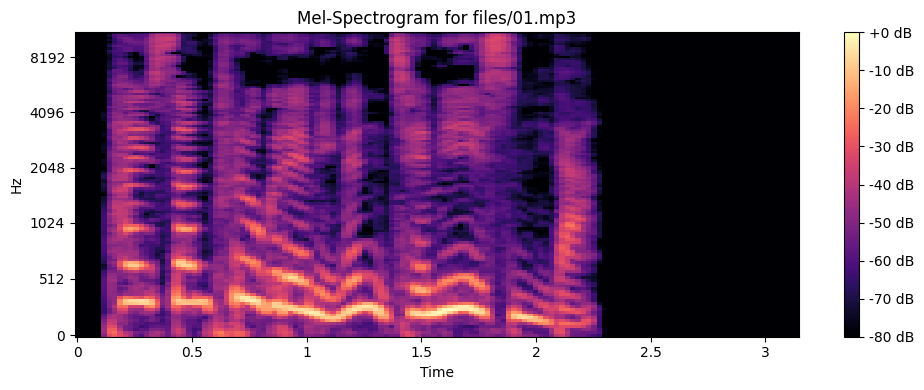

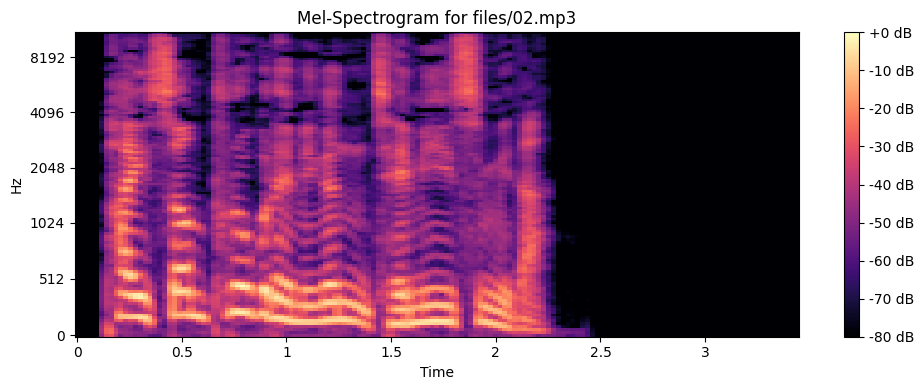

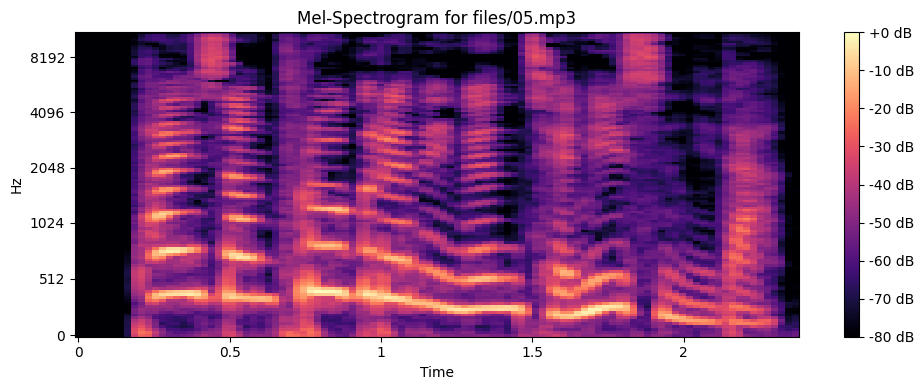

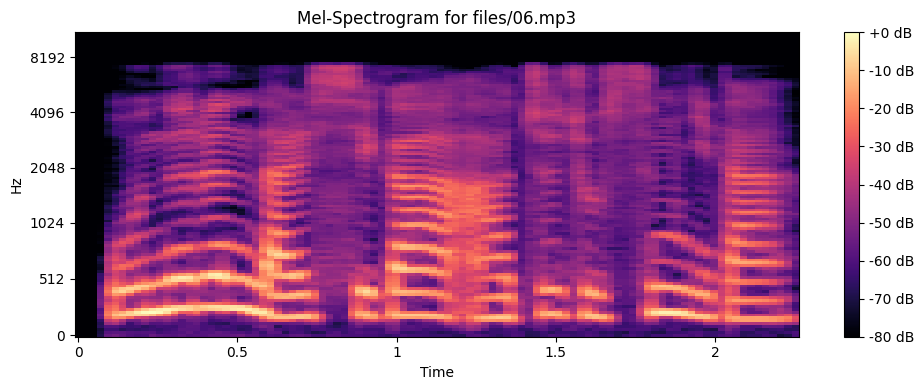

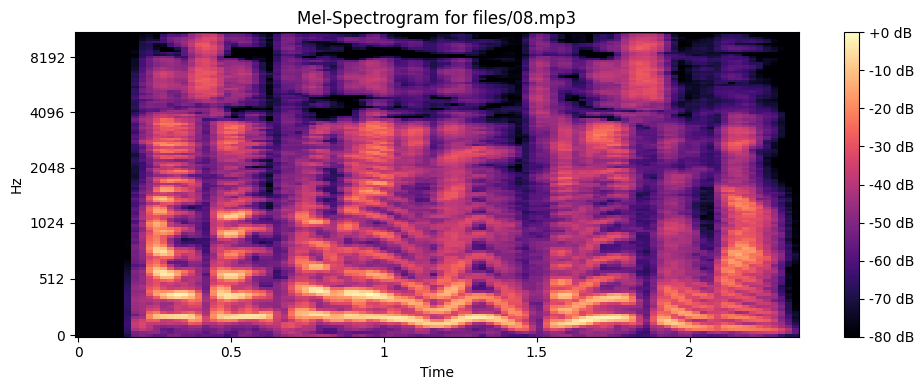

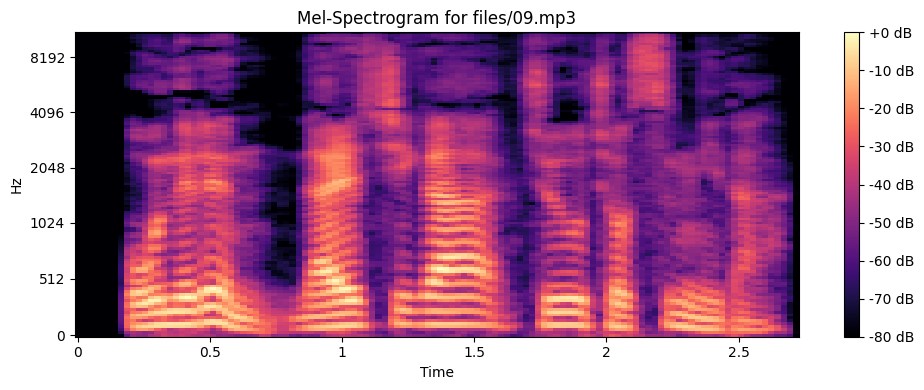

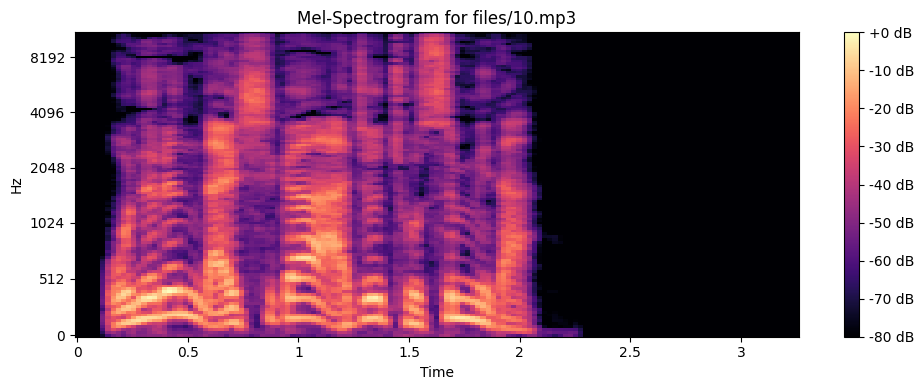

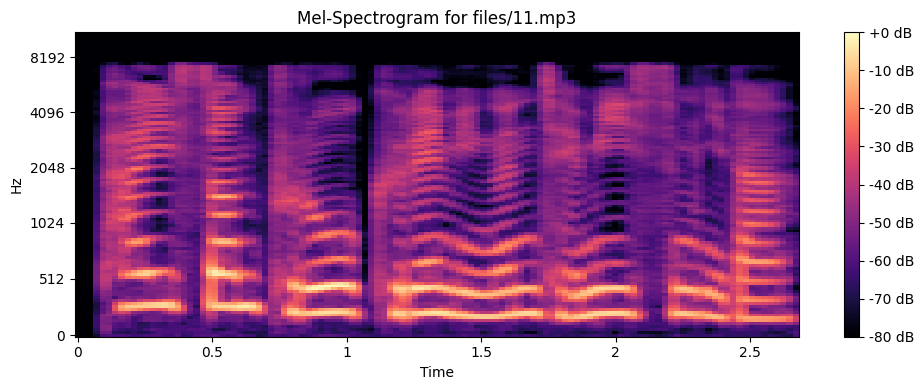

In [16]:
import librosa
import numpy as np

import librosa.display
import matplotlib.pyplot as plt

# Loop through the files 01.mp3 to 12.mp3
for audio_path in file_list:
    y, sr = librosa.load(audio_path)
    
    # Generate the mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Display the mel-spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-Spectrogram for {audio_path}')
    plt.tight_layout()
    plt.show()

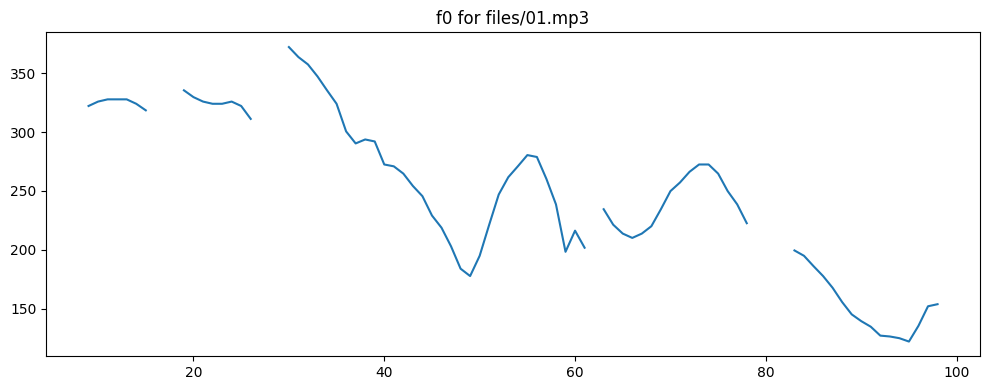

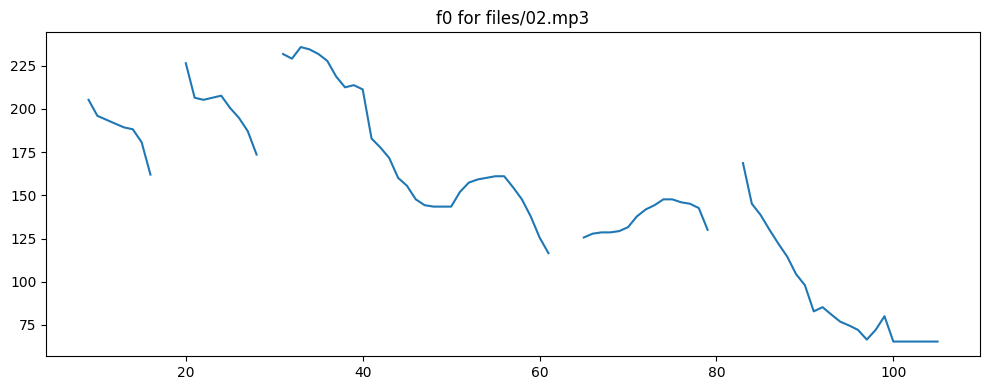

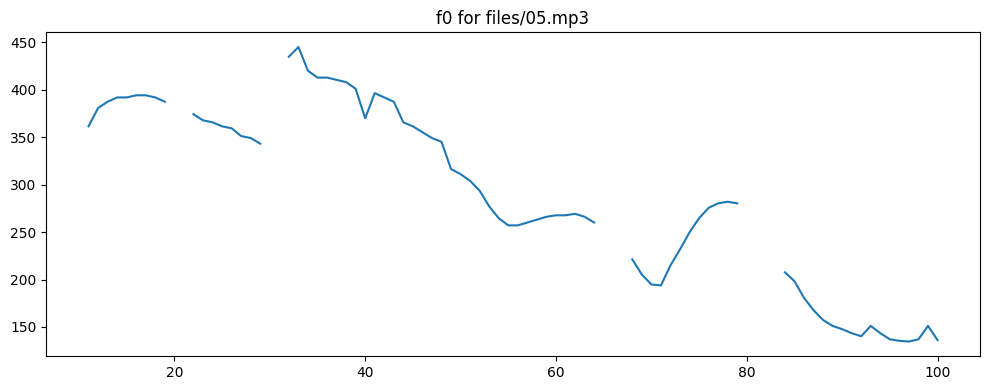

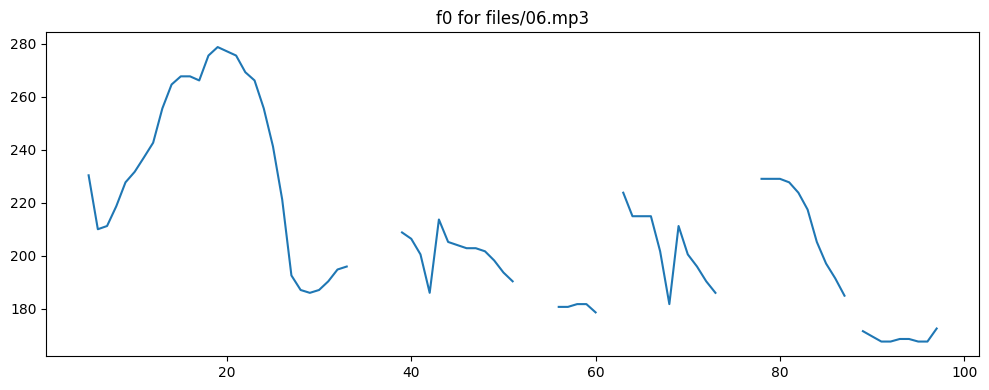

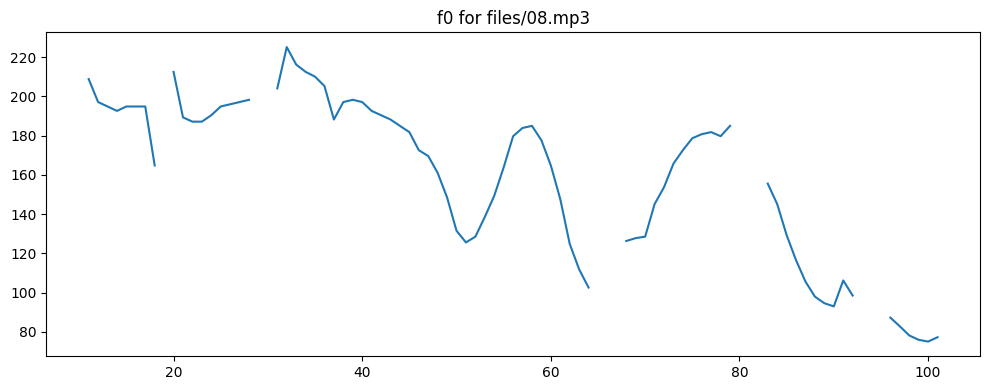

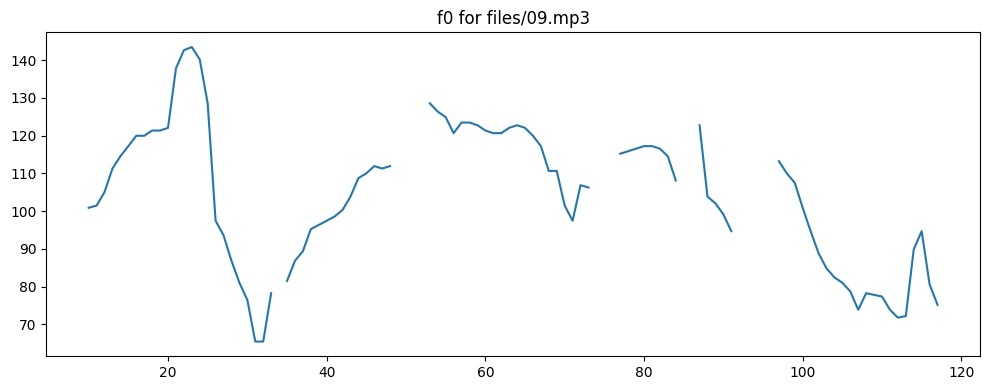

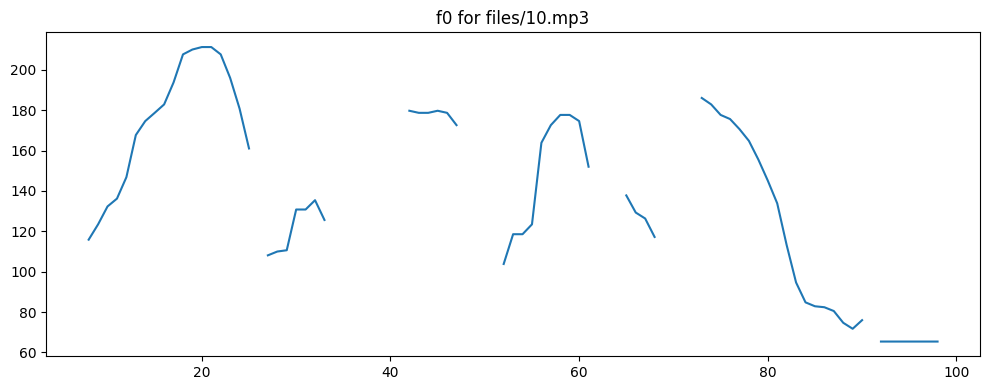

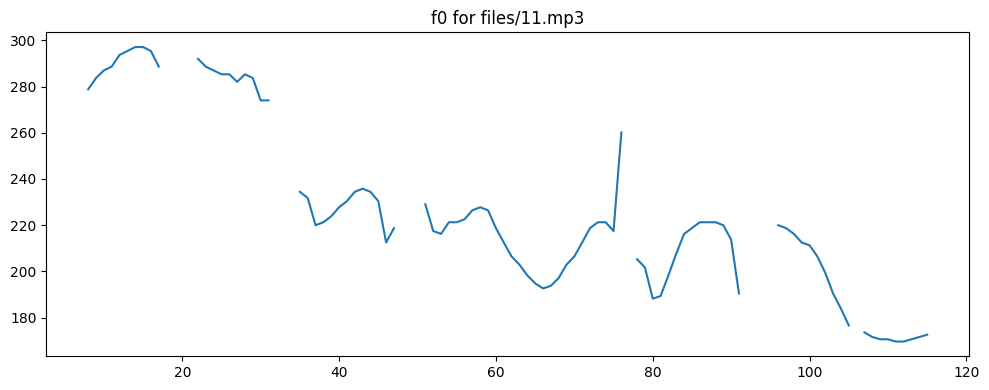

In [18]:

# 기본 주파수 분석 - 기본 주파수 시각화
# 기본 주파수(F0)이며, 소리에서 가장 낮은 주파수를 말합니다.
# 이 값에 따라 소리의 높낮이를 판단할 수 있습니다.
# pyin 함수 - librosa의 기본 주파수 추정 함수
for audio_path in file_list:
    y, sr = librosa.load(audio_path)

    # fmin, fmax는 추정할 주파수의 범위를 지정하며 C2와 C7는 음계에서 C2, C7을 의미합니다.
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

   
    # Display the mel-spectrogram
    plt.figure(figsize=(10, 4))
    plt.plot(f0)
    plt.title(f'f0 for {audio_path}')
    plt.tight_layout()
    plt.show()


In [19]:
# 기본 주파수 분석으로 성별을 분류해봅시다.

male_count = 0
female_count = 0

for audio_path in file_list:
    y, sr = librosa.load(audio_path)

    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_mean = f0[~np.isnan(f0)].mean()  # 소리가 빈 영역을 제외하기 위해서 사용하는 numpy 배열 전용 인덱싱 방법
    # 85Hz ~ 150Hz는 일반 남성의 목소리 주파수 범위
    # 165Hz ~ 255Hz는 일반 여성의 목소리 주파수 범위
    # 그러므로 아래 코드는 문제가 있음
    if 85 <= f0_mean <= 180:
        print(f'{audio_path}: 남성 목소리로 분류 with mean f0 = {f0_mean:.2f} Hz')
        male_count += 1
    elif 165 <= f0_mean <= 255:
        print(f'{audio_path}: 여성 목소리로 분류 with mean f0 = {f0_mean:.2f} Hz')
        female_count += 1
    else:
        print(f'{audio_path}: 명확히 분류되지 않음 with mean f0 = {f0_mean:.2f} Hz')

print(f'Total Male voices: {male_count}')
print(f'Total Female voices: {female_count}')

files/01.mp3: 여성 목소리로 분류 with mean f0 = 248.36 Hz
files/02.mp3: 남성 목소리로 분류 with mean f0 = 150.30 Hz
files/05.mp3: 명확히 분류되지 않음 with mean f0 = 290.39 Hz
files/06.mp3: 여성 목소리로 분류 with mean f0 = 210.91 Hz
files/08.mp3: 남성 목소리로 분류 with mean f0 = 160.78 Hz
files/09.mp3: 남성 목소리로 분류 with mean f0 = 104.47 Hz
files/10.mp3: 남성 목소리로 분류 with mean f0 = 139.46 Hz
files/11.mp3: 여성 목소리로 분류 with mean f0 = 225.81 Hz
Total Male voices: 4
Total Female voices: 3


In [23]:
f0_dict = {}
for audio_path in file_list:
    y, sr = librosa.load(audio_path)

    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_mean = f0[~np.isnan(f0)].mean()  # 소리가 빈 영역을 제외하기 위해서 사용하는 numpy 배열 전용 인덱싱 방법
    f0_dict[audio_path] = f0_mean

# f0_dict를 값을 기준으로 정렬
# 만약 4개가 남성, 4개가 여성 목소리라는 것을 알고 있다면...
sorted_f0_dict = dict(sorted(f0_dict.items(), key=lambda item: item[1]))
for i, key in enumerate(sorted_f0_dict):
    if i < 4:
        print(f'{key:02}.mp3: 남성 목소리로 분류 with mean f0 = {sorted_f0_dict[key]:.2f} Hz')
    else:
        print(f'{key:02}.mp3: 여성 목소리로 분류 with mean f0 = {sorted_f0_dict[key]:.2f} Hz')

files/09.mp3.mp3: 남성 목소리로 분류 with mean f0 = 104.47 Hz
files/10.mp3.mp3: 남성 목소리로 분류 with mean f0 = 139.46 Hz
files/02.mp3.mp3: 남성 목소리로 분류 with mean f0 = 150.30 Hz
files/08.mp3.mp3: 남성 목소리로 분류 with mean f0 = 160.78 Hz
files/06.mp3.mp3: 여성 목소리로 분류 with mean f0 = 210.91 Hz
files/11.mp3.mp3: 여성 목소리로 분류 with mean f0 = 225.81 Hz
files/01.mp3.mp3: 여성 목소리로 분류 with mean f0 = 248.36 Hz
files/05.mp3.mp3: 여성 목소리로 분류 with mean f0 = 290.39 Hz


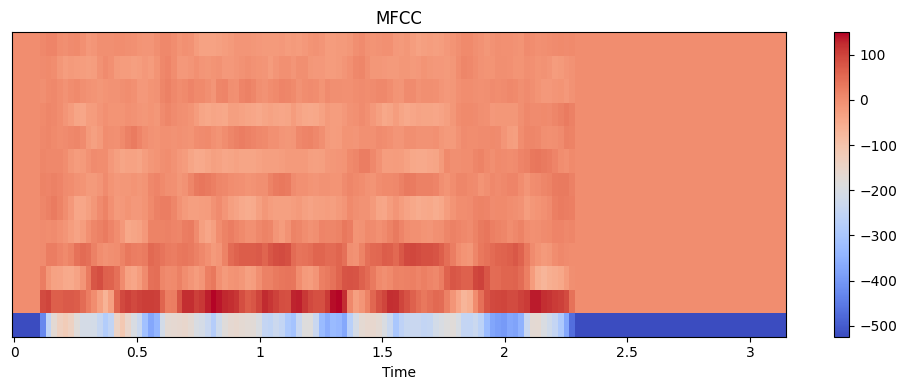

Mean MFCCs: [-327.44928     51.911377    11.365017    25.343456     2.275225
   -9.432724     3.0090036   -9.089207    -1.0487188  -12.522669
   -0.8483139   -7.8518543   -6.7021313]


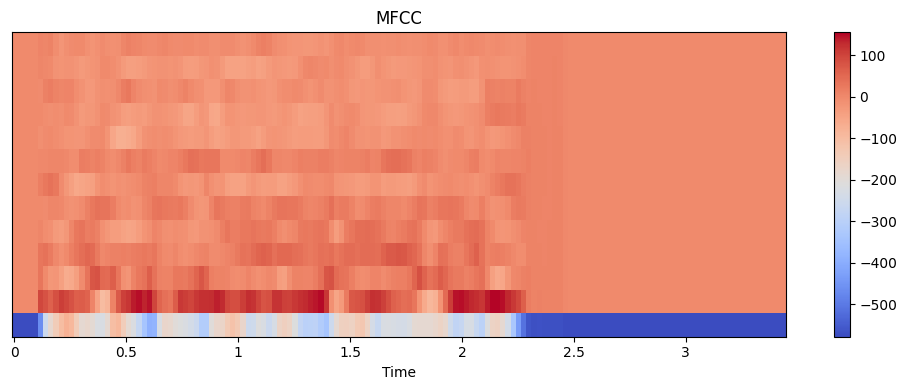

Mean MFCCs: [-351.86557     52.191402    10.549677    17.322975     3.649645
    7.9007487   -8.223779     7.98971    -11.865876   -11.227388
   -5.642797   -11.962174    -3.4652922]


In [24]:
# MFCC 특징 추출
# MFCC는 음성 신호의 특징을 추출하는 데 사용되는 기술로, 음성 신호를 주파수 영역에서 시간 영역으로 변환합니다.
# librosa의 mfcc 함수를 사용하여 음성 신호의 MFCC를 추출할 수 있습니다.
# 결괏값은 13개의 MFCC 계수로 이루어진 배열입니다.
# 배열의 각 값은 시간에 따른 음성 신호의 특징으로, 각 값은 시간에 따라 변화합니다.
# 첫 번째 계수 - 전체 음성 신호의 에너지를 나타냅니다.
# 나머지 계수는 앞쪽 일수록 저주파수, 뒤쪽으로 갈수록 고주파수를 나타냅니다.
# 의미로는 저주파수는 음성 신호의 전체적인 특징을 나타내고, 고주파수는 음성 신호의 세부적인 특징을 나타냅니다.

files = ['files/01.mp3', 'files/02.mp3']
def mfcc_extraction(audio_path):
    y, sr = librosa.load(audio_path)
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Display the MFCC features
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

    # Calculate the mean MFCCs
    mfccs_mean = np.mean(mfccs, axis=1)
    print(f'Mean MFCCs: {mfccs_mean}')

for file in files:
    mfcc_extraction(file)

In [30]:
# energy를 제외한 각각의 정보는 모두 시간의 흐름에 따른 배열의 형태로 반환되며,
# 하나의 값은 프레임 단위로 계산된 값입니다.
# 프레임은 일정 시간 동안의 음성 신호에 해당되는데, n_fft와 hop_length에 따라 정해지며
# n_fft와 hop_length를 지정하지 않으면 librosa의 기본값이 사용됩니다.
# librosa의 기본값은 n_fft=2048, hop_length=512입니다.

def etc_info(audio_path):
    y, sr = librosa.load(audio_path)

    # 에너지 - 음성 신호의 전체적인 크기를 나타냅니다.
    energy = np.sum(y ** 2)

    # RMS 에너지 - 음성 신호의 에너지의 제곱근을 나타냅니다.
    rms_energy = librosa.feature.rms(y=y)

    # 제로 크로싱 레이트 - 음성 신호가 0을 통과하는 횟수를 나타냅니다.
    zero_crossings = librosa.feature.zero_crossing_rate(y)

    # 스펙트럼 센트로이드 - 음성 신호의 "무게중심"에 해당하는 값입니다.
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

    # 스펙트럼 대역폭 - 음성 신호의 주파수가 얼마나 넓게 펴져 있는지를 나타냅니다.
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    # 스펙트럼 대조 - 가장 높은 에너지 주파수 대역과 가장 낮은 주파수 대역의 차이를 나타냅니다.
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    # 스펙트럼 평탄도 - 음성 신호의 주파수 대역의 평탄도를 나타냅니다. (소리가 얼마나 일관된지 판단)
    spectral_flatness = librosa.feature.spectral_flatness(y=y)

    # 피치 - 소리의 높낮이
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr) 
    
    # 공명 주파수 대역 (주로 모음의 주파수 대역)
    lpc_coeffs = librosa.lpc(y, order=2)
    
    # HNR - Harmonic-to-Noise Ratio, 조화 대 잡음 비율
    # 소리의 깨끗함, 발화자의 상태나 목소리 품질을 나타냄
    hnr = librosa.effects.harmonic(y)

    # Autocorrelation - 소리의 주기성 분석
    autocorr = librosa.autocorrelate(y)

    # 결과 출력
    print(f'Energy: {energy}')
    print(f'RMS Energy: {rms_energy}')
    print(f'Zero-Crossings: {zero_crossings}')
    print(f'Spectral Centroid: {spectral_centroid}')
    print(f'Spectral Bandwidth: {spectral_bandwidth}')
    print(f'Spectral Contrast: {spectral_contrast}')
    print(f'Spectral Flatness: {spectral_flatness}')
    print(f'Pitches: {pitches}')
    print(f'LPC Coefficients: {lpc_coeffs}')
    print(f'HNR: {hnr}')
    print(f'Autocorrelation: {autocorr}')

for file in files:
    etc_info(file)


Energy: 1300.2022705078125
RMS Energy: [[0.00000000e+00 0.00000000e+00 0.00000000e+00 3.98663876e-13
  6.34254457e-06 1.63886026e-02 2.26914473e-02 4.29256149e-02
  1.03756338e-01 1.53036132e-01 1.79820552e-01 2.03629985e-01
  1.96582690e-01 1.61690980e-01 1.31576598e-01 8.45962241e-02
  3.62331569e-02 7.34640211e-02 1.42023712e-01 1.71251684e-01
  1.86485156e-01 1.84655324e-01 1.50949836e-01 1.22323461e-01
  9.62839648e-02 7.59361312e-02 4.74895202e-02 2.67024692e-02
  5.47408238e-02 1.11670651e-01 1.69143587e-01 2.13313431e-01
  2.43123919e-01 2.31802791e-01 1.94879502e-01 1.55629635e-01
  1.39777213e-01 1.36919886e-01 1.75252452e-01 2.03326210e-01
  1.98585272e-01 2.14777827e-01 2.13013366e-01 2.28220761e-01
  2.36660957e-01 2.26594016e-01 2.06359223e-01 1.60234004e-01
  1.33134112e-01 1.36803165e-01 1.60867646e-01 1.85464606e-01
  1.98259726e-01 2.03799695e-01 2.02713966e-01 1.98568895e-01
  1.78604111e-01 1.51938915e-01 1.16188765e-01 6.02206923e-02
  3.57462578e-02 4.54398394e-02